In [3]:
%matplotlib inline
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=1

import os
import cv2
import numpy as np
import torch
from torch.autograd import Variable
import quat_math
import pickle

from PIL import Image
import scipy.io as scio
from functools import partial
from object_pose_utils.utils import to_np, to_var

import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = 20, 12
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1


In [21]:
from quat_math import quat2AxisAngle
from mpl_toolkits.mplot3d import Axes3D

def quats2Point(quats):
    pts = []
    for q in quats:
        xi, theta = quat2AxisAngle(q)
        pts.append(xi*theta)
    return np.array(pts)

def scatterSO3(vertices, vals, q_gt = None, alpha_max = 1.0, ax = None):
    cmap = plt.get_cmap('jet')
    if(ax is None):
        fig = plt.figure()
        ax = fig.add_subplot(1,1,1, projection='3d')

    #c = cmap(vals)
    a = np.maximum(0,np.minimum(1, (vals - min(vals))/(max(vals) - min(vals))))
    c = cmap(a)
    
    c[:,3] = alpha_max*a

    pts = quats2Point(vertices)
    ax.scatter(pts[:,0], pts[:,1], pts[:,2], s=a*10, c=c)

    if(q_gt is not None):
        pt_gt = quats2Point(q_gt)
        ax.scatter(pt_gt[:,0], pt_gt[:,1], pt_gt[:,2], c='r', marker='x')

In [6]:
video_len = 3
interval = 4
feature_key = 'fc6'

mat_filename_format = 'results/{}/{}_' + '{}_results.mat'.format(feature_key)
print(mat_filename_format)

results/{}/{}_fc6_results.mat


In [8]:
from object_pose_utils.datasets.ycb_dataset import YcbDataset as YCBDataset
from object_pose_utils.datasets.ycb_video_dataset import YcbVideoDataset as YCBVideoDataset
from object_pose_utils.datasets.pose_dataset import OutputTypes as otypes

dataset_root = '/ssd0/datasets/ycb/YCB_Video_Dataset'

with open('{0}/image_sets/classes.txt'.format(dataset_root)) as f:                                    
    classes = f.read().split()
classes.insert(0, '__background__')

object_list = list(range(1,22))
mode = "test"

output_format = [otypes.OBJECT_LABEL,
                 otypes.QUATERNION, 
                 ]

ycb_dataset = YCBDataset(dataset_root, mode=mode, 
                         object_list = object_list, 
                         output_data = output_format, 
                         image_size = [640, 480], num_points=1000)

dataset = YCBVideoDataset(ycb_dataset, 
                          interval = interval, 
                          video_len = video_len)

grid_root = '/scratch/bokorn/results/posecnn_feat_all/'
grid_vertices = torch.load(os.path.join(grid_root, 'grid',
            '{}_vertices.pt'.format(ycb_dataset.classes[1])))
grid_size = grid_vertices.shape[0]


In [9]:
os.path.join(grid_root, 'grid', '{}_vertices.pt'.format(ycb_dataset.classes[1]))

'/scratch/bokorn/results/posecnn_feat_all/grid/002_master_chef_can_vertices.pt'

In [88]:
from object_pose_utils.utils.interpolation import BinghamInterpolation, TetraInterpolation
from object_pose_utils.utils.multi_view_utils import applyTransformBatch

tetra_interp = TetraInterpolation(2)

def combineHistTetra(dists, trans, grid_vertices, confidence = None):
    num_dists = len(dists)
    if(confidence is None):
        confidence = np.ones(num_dists)
        
    grid_size = dists[0].shape
    joint_dist = np.ones(grid_size)
        
    for d, mat, w in zip(dists, trans, confidence):
        grid_vertices_inv = applyTransformBatch(grid_vertices, np.linalg.inv(mat))
        tetra_interp.setValues(d)
        v_interp = tetra_interp.smooth(grid_vertices_inv)
        
        joint_dist *= w*v_interp + (1-w)
        
    return joint_dist


bing_interp = BinghamInterpolation(grid_vertices.cuda(), sigma=30)

def combineHistBingham(dists, trans, vertices, sigmas, confidence = None):
    num_dists = len(dists)
    if(confidence is None):
        confidence = np.ones(num_dists)
        
    grid_size = dists[0].shape
    joint_dist = torch.ones(grid_size)
    for d, mat, w in zip(dists, trans, confidence):
        grid_vertices_inv = applyTransformBatch(vertices, np.linalg.inv(mat))
        
        bing_interp.setValues(d.flatten().cuda())
        v_interp = bing_interp(grid_vertices_inv.cuda())
        
        joint_dist *= w*v_interp + (1-w)
        
    return joint_dist

TypeError: __init__() missing 1 required positional argument: 'values'

In [64]:
from generic_pose.datasets.ycb_dataset import getYCBSymmeties
from object_pose_utils.utils.pose_processing import symmetricAngularDistance, meanShift
import pathlib


import scipy.io as scio
from tqdm import tqdm_notebook as tqdm

grid_size = 3885

err = {}
lik = {}
err_max_shift = {}


with torch.no_grad():
    for obj_id in tqdm(object_list):
        sym_axis, sym_ang = getYCBSymmeties(obj_id)
        dataset.setObjectId(obj_id)
        
        err[obj_id]= {}
        lik[obj_id]= {}
        err_max_shift[obj_id]= {}
        for v_id in dataset.getVideoIds():
            
            dataset.setVideoId(v_id)
            err[obj_id][v_id] = []
            lik[obj_id][v_id] = []
            err_max_shift[obj_id][v_id] = []
            for j, (data, trans) in tqdm(enumerate(dataset), total=len(dataset)):
                #obj, quat = data
                if(len(data) == 0):
                    err[obj_id][v_id].append(np.nan)
                    lik[obj_id][v_id].append(np.nan)
                    err_max_shift[obj_id][v_id].append(np.nan)
                    continue
                quat = data[0][1]
                    
                dists = []
                
                for path in dataset.getPaths(j):
                    dist_path = mat_filename_format.format(path, ycb_dataset.classes[obj_id])
                    dist_data = scio.loadmat(dist_path)
                    dists.append(dist_data['dist_est'].flatten())

                dist_joint = torch.tensor(combineHistBingham(dists, trans, grid_vertices))
                mode_quat = grid_vertices[np.argmax(dist_joint)].unsqueeze(0)
                v_shift = meanShift(mode_quat.cuda(), grid_vertices.cuda(), dist_joint.unsqueeze(1).float().cuda(),
                                    sigma=np.pi/9, max_iter = 100)
        
                err[obj_id][v_id].append(symmetricAngularDistance(mode_quat, quat.unsqueeze(0),
                                      sym_axis, sym_ang).item()*180/np.pi)
            
                err_max_shift[obj_id][v_id].append(symmetricAngularDistance(v_shift.cpu(), quat.unsqueeze(0),
                                                sym_axis, sym_ang).item()*180/np.pi)

                
                savepath = 'results/{}'.format(dataset.getPaths(j)[0])
                pathlib.Path(savepath).mkdir(parents=True, exist_ok=True)

                tetra_interp.setValues(to_np(dist_joint.flatten()))
                lik[obj_id][v_id].append(tetra_interp.smooth(to_np(quat)).item())
            
                if(False):
                    scio.savemat('{}/{}_{}_{}x{}_results.mat'.format(savepath, 
                                                           ycb_dataset.classes[obj_id], 
                                                           feature_key,
                                                           video_len, interval),
                            {'index':j,
                             'quat':to_np(quat),
                             'mode_quat':to_np(mode_quat),
                             'dist_est':to_np(dist_joint),
                             'lik':lik[obj_id][v_id][-1],
                             'err':err[obj_id][v_id][-1],
                             'err_max_shift':err_max_shift[obj_id][v_id][-1],
                             })
np.savez('results/hist_filter_{}_{}x{}.npz'.format(feature_key, video_len, interval), 
         lik=lik,
         err=err,
         err_max_shift=err_max_shift)

KeyboardInterrupt: 

In [87]:
scatterSO3(to_np(grid_vertices), dist_joint, [to_np(data[0][1])], alpha_max = 1, ax = None)

KeyError: '0 is not a file in the archive'

In [85]:
data = np.load('results/hist_filter__feat_global_reg_results_3x4.npz', allow_pickle=True)
lik = data['lik'].item()
err = data['err'].item()
err_shift = data['err_max_shift'].item()


In [86]:
for obj in object_list:
    for v_id in lik[obj].keys():
        print('{}: {} Video {}: {:0.2f}, {:0.2f}, {:0.2f}'.format(obj, ycb_dataset.classes[obj], v_id,
                                            np.nanmean(np.log(lik[obj][v_id])), 
                                            np.nanmean(err[obj][v_id]),
                                            np.nanmean(err_shift[obj][v_id])))
              
        

1: 002_master_chef_can Video 0048: 0.05, 81.53, 82.20
1: 002_master_chef_can Video 0051: 1.95, 58.94, 54.21
1: 002_master_chef_can Video 0055: -1.98, 166.12, 169.15
1: 002_master_chef_can Video 0056: 2.23, 38.57, 34.38
2: 003_cracker_box Video 0050: -0.34, 62.91, 64.01
2: 003_cracker_box Video 0054: 2.42, 19.51, 17.93
2: 003_cracker_box Video 0059: 1.34, 31.20, 28.34
3: 004_sugar_box Video 0049: 2.55, 13.64, 10.44
3: 004_sugar_box Video 0051: 0.84, 60.95, 58.85
3: 004_sugar_box Video 0054: 2.61, 17.10, 15.71
3: 004_sugar_box Video 0055: 2.24, 17.83, 15.73
3: 004_sugar_box Video 0058: 2.73, 15.67, 11.56
4: 005_tomato_soup_can Video 0050: 1.19, 39.23, 34.74
4: 005_tomato_soup_can Video 0051: -1.57, 79.38, 73.94
4: 005_tomato_soup_can Video 0053: 2.42, 20.07, 17.21
4: 005_tomato_soup_can Video 0055: 2.15, 21.62, 22.00
4: 005_tomato_soup_can Video 0057: 2.20, 20.24, 17.81
4: 005_tomato_soup_can Video 0059: 2.47, 16.79, 12.36
5: 006_mustard_bottle Video 0050: 2.36, 16.08, 12.93
5: 006_musta

/home/bokorn/src/generic_pose/bpy/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.


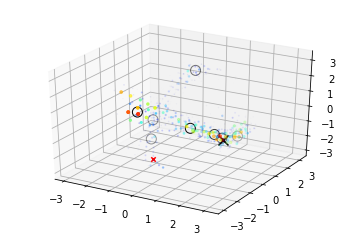

In [56]:
from object_pose_utils.utils.pose_processing import meanShift, unique_tol

v_shift = meanShift(grid_vertices.cuda(),
                    grid_vertices.cuda(), 
                    dist_joint.float().unsqueeze(1).cuda(),
                    sigma=np.pi/9,
                    max_iter = 100)

v_shift, counts = unique_tol(v_shift, tol=1*np.pi/180, return_counts = True)
v_shift = v_shift[torch.tensor(counts) > 200]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatterSO3(to_np(grid_vertices), to_np(dist_joint), [to_np(quat)], alpha_max = 1, ax = ax)

pts = quats2Point(to_np(v_shift))
ax.scatter(pts[:,0], pts[:,1], pts[:,2], s=100, marker='o', facecolors='none', edgecolors='k')

pts = quats2Point(to_np(grid_vertices[torch.argmax(dist_joint)].unsqueeze(0)))
ax.scatter(pts[:,0], pts[:,1], pts[:,2], s=100, marker='x', c='k')

plt.show()

In [48]:
print(symmetricAngularDistance(grid_vertices[torch.argmax(dist_joint)].unsqueeze(0).cpu(), quat.unsqueeze(0),
                         sym_axis, sym_ang).item()*180/np.pi)

print(symmetricAngularDistance(v_shift.cpu(), quat.unsqueeze(0),
                         sym_axis, sym_ang).item()*180/np.pi)


152.71038033114226
141.83237517216983


In [ ]:
from quat_math import euler_matrix, quaternion_matrix, quaternion_about_axis

def getYCBTransform(q, t=[0,0,1]):
    trans_mat = quaternion_matrix(q)
    ycb_mat = euler_matrix(-np.pi/2,0,0)
    trans_mat = trans_mat.dot(ycb_mat)
    trans_mat[:3,3] = t
    return trans_mat

from object_pose_utils.utils.image_preprocessing import transparentOverlay
def imshowCV(img, axis = False, show = True):
    if not axis:
        plt.axis('off')
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    if(show):
        plt.show()
    
def imshow(img, axis = False, colorbar = False, show = True):
    if not axis:
        plt.axis('off')
    plt.imshow(img)
    if(colorbar):
        plt.colorbar()
    if(show):
        plt.show()
    

In [ ]:
from model_renderer.pose_renderer import BpyRenderer
from generic_pose.datasets.ycb_dataset import ycbRenderTransform

renderer = BpyRenderer(transform_func = ycbRenderTransform)


fx = 1066.778
fy = 1067.487
px = 312.9869
py = 241.3109
camera_dist = 0.33

renderer.setCameraMatrix(fx, fy, px, py, 640, 480)
renderer.setDepth()
model_cls = None

In [ ]:
renderer.deleteAll()
if(model_cls != classes[int(obj_id)]):
    model_cls = classes[int(obj_id)]
    model_filename = '{}/models/{}/textured.obj'.format(dataset_root, model_cls)
    renderer.deleteAll()
    renderer.loadModel(model_filename, emit = 0.5)

In [ ]:
obj_id = 13

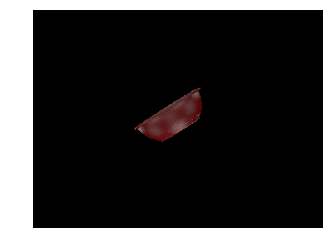

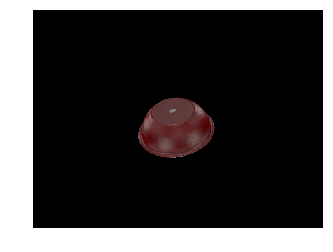

In [57]:
q = to_np(grid_vertices[torch.argmax(dist_joint)])

trans_mat = getYCBTransform(q, [0,0,1])
image, depth = renderer.renderTrans(trans_mat)
imshowCV(image)


trans_mat = getYCBTransform(quat, [0,0,1])
image, depth = renderer.renderTrans(trans_mat)
imshowCV(image)
